# 4. Project prototype

Important note: Whenever I include code other than my own I always include the soruce of the code right above it. If a code snippet doesn't include a reference to a source, you should assume it's done by me.

## Install Dependencies and import libraries

In [1]:
# pip install pandas numpy yfinance pandas-ta scikit-learn tensorflow

In [142]:
# https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)
# import yfinance, our data source
import yfinance as yf

# https://pypi.org/project/pandas-ta/ ("""An easy to use Python 3 Pandas Extension with 130+ Technical Analysis Indicators. Can be called from a Pandas DataFrame or standalone""")
# import pandas-ta
import pandas_ta as ta

# import pandas and numpy
import pandas as pd 
import numpy as np

# import matplotlib for data visualisation
import matplotlib.pyplot as plt

# import from scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# import from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical

## Select and download the stocks histroical prices data

For this prototype we will consider the following stocks from the S&P500 index.
we will take 5 random stocks from the S&P500 index list.
<br>
Ranks are as of June 6, 2024 from https://www.slickcharts.com/sp500[9]
- Rank 48 Pfizer Inc. 'PFE'
- Rank 150 Roper Technologies, Inc. 'ROP'
- Rank 251 Xylem Inc 'XYL'
- Rank 350 Corpay, Inc. 'CPAY'
- Rank 450 Incyte Genomics Inc 'INCY'

In [3]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

For now we will download the selected stocks weekly price data for the last 10 years

In [4]:
# we will take the weekly data for the last 10 years
data_weekly = yf.download(symbols_list, period='10y', interval='1wk')

[*********************100%%**********************]  5 of 5 completed


## Format the data and save it as a CSV file

Reshape the dataframe so it has the ticker as a second index

In [5]:
# source of inspiration: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html[10]
# Return a reshaped DataFrame having a multi-level inde
stacked_data_weekly = data_weekly.stack()
stacked_data_weekly

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2014-06-16 CPAY    131.300003  131.300003  134.020004  131.270004  132.339996   
           INCY     56.389999   56.389999   56.480000   53.259998   53.470001   
           PFE      19.280016   28.254269   28.387096   27.817837   27.988615   
           ROP     140.396454  148.940002  151.449997  145.639999  146.070007   
           XYL      34.891251   39.669998   39.840000   38.130001   38.490002   
...                       ...         ...         ...         ...         ...   
2024-06-10 CPAY    249.660004  249.660004  260.480011  247.690002  257.369995   
           INCY     62.110001   62.110001   63.080002   57.970001   59.009998   
           PFE      27.530001   27.530001   28.350000   27.200001   28.350000   
           ROP     549.450012  549.450012  559.080017  546.320007  553.340027   
           XYL     138.020004  138.020004  141.440002  135.990005  136.929993   

Price                 Volume  
Date       Ticker             
2014-06-16 CPAY      3264600  
           INCY      5245100  
           PFE     120431095  
           ROP       2283100  
           XYL       5001800  
...                      ...  
2024-06-10 CPAY      2454326  
           INCY     40269916  
           PFE     186707321  
           ROP       2479378  
           XYL       5211797  

[2610 rows x 6 columns]

#### What are we looking at?
Date: one of the indexes and is the date in which the information on the reset of the columns takes place.
<br>
Ticker: an abbreviation of the company's share listed on the exchanges.
<br>
Adjusted close: is the closing price after adjustments for all applicable splits and dividend distributions.
<br>
Close: is the closing price of the stock, on that timeframe, (here it's a week).
<br>
High: is the highest point a stock has reached in the given timeframe.
<br>
Low: is the lowest point a stock has reached in the given timeframe.
<br>
Open: the opening price of the stock on that timeframe.
<br>
Volume: the volume of stocks were traded on that timeframe.

<br>

Usually for this type of models we would only keep either Adjusted close or close but we will leave theme both for now.

Save the data to a CSV so we don't have to make any extra unnecessary requests to the API every time we reload the notebook

In [6]:
# save the dataframe to a csv file
stacked_data_weekly.to_csv('stacked_data_weekly_1.csv', index=True)

# load the the dataframe from the csv file
df = pd.read_csv('stacked_data_weekly_1.csv').set_index(["Date", "Ticker"])

In [146]:
# df.head(5)

## Perform simple exploritory data analysis

In [8]:
# how many null values in each column
df.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [9]:
# the data shape
df.shape

(2610, 6)

In [10]:
# data basic stats
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000,2.610000e+03
mean,143.059409,146.447467,149.962876,142.409679,146.169125,3.119915e+07
std,124.192610,124.335424,126.709936,121.474554,124.059476,5.985591e+07
min,18.176516,25.400000,26.170000,25.200001,25.580000,7.871000e+05
25%,47.494984,51.402501,52.724999,50.005001,51.464999,2.760175e+06
50%,94.508144,95.530003,98.750000,91.770000,95.900002,4.944450e+06
75%,205.752495,207.637493,213.142498,201.555000,207.604996,9.477575e+06
max,560.067810,560.840027,565.000000,547.809998,562.349976,6.333997e+08


## Devide the data into five dataframes, one for each stock

In [11]:
# source of inspiration https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html [11]
# select specific stock data at the 'Ticker' level of this multi index dataframe
df1 = df.xs('PFE', axis=0, level='Ticker', drop_level=True)
df2 = df.xs('ROP', axis=0, level='Ticker', drop_level=True)
df3 = df.xs('XYL', axis=0, level='Ticker', drop_level=True)
df4 = df.xs('CPAY', axis=0, level='Ticker', drop_level=True)
df5 = df.xs('INCY', axis=0, level='Ticker', drop_level=True)

# disply the first dataframe
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-06-16,19.280016,28.254269,28.387096,27.817837,27.988615,120431095
2014-06-23,19.208803,28.149904,28.320683,27.656546,28.282732,137236386
2014-06-30,19.765581,28.965843,29.070210,28.074003,28.235294,83568393
2014-07-07,19.467768,28.529411,29.060720,28.064516,28.927895,104542888
2014-07-14,19.895060,29.155598,29.705881,28.557875,28.643265,151018491


In [12]:
# show the new df shape
df1.shape

(522, 6)

## Create the target of the model

Now after this point in the prototype we will only work with df1 which includes the historical stock prices data for the last 10 years for Pfizer Inc. or 'PFE'. This is so we don't make the this prototype too lengthy. However you can easily tell that it's going to be the exact same steps we can follow to train the model on any of the other 4 stocks dataframes. For the final project report we will include at least 5 different stocks data to make sure that our model generalises well.

We are going to try and predict the stock trend based on its past data, that is we will try to predict if the stock price will go up or down, if we know the stock price will go up in the future, we can buy it now and sell it for a profit if the model estimation were correct. also if we know the stock will go down in the future, we can sell it (or short it) now, so our assets won't depreciate in value. 

To do that we will create 2 new columns: 
- 'Next' column where the values for this column will be equal to the next closing price. This is will be the target for the regression model.
- 'trend' column where the values for this column will be either 1 or 0 depending on whether the 'Next' closing price will be higher than the closing price. This will be the target for the classification model, which what we will be using in this prototype.

In [14]:
# copy the dateframe before modification so we don't get a warning from jupyter notebook
df1 = df1.copy()

# create the 'Next' column to be equal to the next closing price
# this can be accomplished easily by shifting the close column backward by 1
df1["Next"] = df1['Close'].shift(-1)

In [15]:
# create a function that returns 1 if the the next closing price is higher than current closing price and 0 otherwise.
def assign_trend(row):
    if row['Next'] > row['Close']:
        return 1
    elif row['Next'] < row['Close']:
        return 0
    else: # if the next value is missing then return NaN
        return np.nan


# create the 'Trend' column to be equal to the output of the 'assign_trend' function    
df1['Trend'] = df1.apply(assign_trend, axis=1)

In [16]:
# check out the results
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume,Next,Trend
Date,,,,,,,,
2014-06-16,19.280016,28.254269,28.387096,27.817837,27.988615,120431095,28.149904,0.0
2014-06-23,19.208803,28.149904,28.320683,27.656546,28.282732,137236386,28.965843,1.0
2014-06-30,19.765581,28.965843,29.070210,28.074003,28.235294,83568393,28.529411,0.0
2014-07-07,19.467768,28.529411,29.060720,28.064516,28.927895,104542888,29.155598,1.0
2014-07-14,19.895060,29.155598,29.705881,28.557875,28.643265,151018491,28.643265,0.0


Check if the data is balanced

In [52]:
# let's check the occurance of each value in the Trend column
df1['Trend'].value_counts()

Trend
1    255
0    238
Name: count, dtype: int64

In [54]:
# percentage of 'trend up' to the whole column
255/df1.shape[0]

0.5172413793103449

We notice that the data is very balanced in this dataframe. This is good because it will mean the model will be less prone to overfitting.

## Create a common sense baseline
It's essential to start our model development by setting a common sense baseline, this is important because we need to make sure the model we will create, will atleast match this logical baseline, otherwise we will be better off not relying on the model at all.
For this problem, stock prediction, a reasonable assumption is to assume the average person will predict the future trend of the stock to be equal to its current trend. In other words if the stock is going up, this person will think it will go up again and vise versa. This is actually a very solid baseline as it's very reminiscent of the real life. This is has something to do with the topic of behaviorl finance[12] but it's outside the scope of this project.

In [18]:
# this can be accomplished easily by shifting the close column forward by 1
common_sense = df1['Trend'].shift(1)

# measure the average of when the common sense (naive) prediction will match the actual 'Trend'
(common_sense == df1['Trend']).mean()

0.5172413793103449

This means if a person make a prediction in this method, they will be 52% of the time correct!

## Include the technical indicators
Adding indictors to the dataframe is an essential steps in improving the model performce, as these will be consiered among the model features list and can have a massive benefits on the model performance.
<br>
There are two ways to include technoical indicators, we can do it manually, which will take a lost of time, and reseach, as well as it's more prone to mistakes. We can also utlize an existing library for this very purpose.
<br>
That's why we will be utilizing the pandas-ta library which not only includes most of the nessarry technical indicators we need to calculate, but it's also designed specifically to work on pandas dataframs which is ideal in our case.

We will use pandas-ta to add all the technical indicators we want to the dataframe 

In [161]:
#  we can easily check the available indicators in the pandas-ta library
# help(df1.ta.indicators())

We notice there are a large list of indicators that we can add easily to our dataframe. This is important for the final report because all the indicators we might need are already available, so we can systematically study each one of them, add them to our features list, and test their impact on the model performance.

In [23]:
#  we can also learn about any specific indicator like this
# help(ta.macd)

For this prototype we will only consider few of the most common technical indicators that are used by analysts and ML models to make an estimation of the stock trend direction.
These are MACD, RSI, SMA, and EMA.
the ta.macd function also returns Signal, and Histogram values. so we will add those too.

In [24]:
# for the time being let's create a function that add all the technical indicators we want to a df
def assign_TIs(_df):
    # apply macd on the Close column in a df and add it to the dataframe    
    mcda = ta.macd(_df["Close"])
    # The MACD (Moving Average Convergence/Divergence) is a popular indicator to that is used to identify a trend
    _df.insert(6, "MACD", mcda["MACD_12_26_9"])
    # Signal is an EMA (exponential moving average) of MACD
    _df.insert(7, "Signal", mcda["MACD_12_26_9"])
    # Histogram is the difference of MACD and Signal
    _df.insert(8, "Histogram", mcda["MACD_12_26_9"])
    
    # apply RSI on the Close column in a df and add it to the dataframe    
    # RSI (Relative Strength Index) is popular momentum oscillator. Measures velocity and magnitude a trend
    rsi = ta.rsi(_df["Close"])
    _df.insert(9, "RSI", rsi)
    
    # apply SMA on the Close column in a df and add it to the dataframe    
    # SMA (Simple Moving Average) is the classic moving average that is the equally weighted average over n periods.
    sma = ta.sma(_df["Close"])
    _df.insert(10, "SMA", sma)
    
    # apply EMA on the Close column in a df and add it to the dataframe    
    # EMA (Exponential Moving Average). The weights are determined by alpha which is proportional to it's length.
    ema = ta.ema(_df["Close"])
    _df.insert(11, "EMA", ema)
    
    return _df

In [25]:
# apply the function to the dataframe
df1 = assign_TIs(df1)

In [29]:
# drop the NaN values
df1.dropna(inplace=True)

In [31]:
# fix the 'Trend' data type to be int
df1 = df1.astype({'Trend': int})

In [32]:
# check the dataframe
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume,MACD,Signal,Histogram,RSI,SMA,EMA,Next,Trend
Date,,,,,,,,,,,,,,
2014-12-08,20.389353,29.364326,31.423149,29.278936,30.151802,144765109,0.546687,0.546687,0.546687,57.179158,28.540797,28.914589,30.303604,1
2014-12-15,21.041546,30.303604,30.445921,29.013283,29.535105,169635081,0.625828,0.625828,0.625828,62.611232,28.807400,29.167137,30.028463,0
2014-12-22,20.850500,30.028463,30.578749,29.193548,30.227703,76542429,0.658753,0.658753,0.658753,60.202062,29.169829,29.323742,29.724857,0
2014-12-29,20.639688,29.724857,30.151802,29.544592,29.848198,57096761,0.652822,0.652822,0.652822,57.569679,29.380455,29.396672,30.977230,1
2015-01-05,21.509279,30.977230,31.024668,29.421251,29.743834,149756432,0.740640,0.740640,0.740640,64.470952,29.636622,29.684046,31.119545,1


In [33]:
# the shape of the data now
df1.shape

(492, 14)

##  Prepare the data for training

We start by removing the unnecessary columns, only 'Date' for now.

In [148]:
# reset the index
df1.reset_index(inplace = True)

# drop the Date column as it's not necessary for now
df1.drop(['Date'], axis=1, inplace=True)

# df1.head(5)

Create the features list, for now we will use every column except the last two.

In [34]:
# The features list
X1 = df1.iloc[:, :-2]

X1.head(2)

,Adj Close,Close,High,Low,Open,Volume,MACD,Signal,Histogram,RSI,SMA,EMA
Date,,,,,,,,,,,,
2014-12-08,20.389353,29.364326,31.423149,29.278936,30.151802,144765109,0.546687,0.546687,0.546687,57.179158,28.540797,28.914589
2014-12-15,21.041546,30.303604,30.445921,29.013283,29.535105,169635081,0.625828,0.625828,0.625828,62.611232,28.807400,29.167137


Create the target, which is the 'Trend' column for now.

In [35]:
# The Target (Trend for now)
y1 = df1.iloc[:, -1]

Scaling numerical data is an important step before training machine learning models as it reduces the impact of outliers on the output of the model, giving us more accurate predictions.
<br>

Since the features are all numercial data, we can scale them easily to a value in the range of 0 to 1 using scikit-learn minmax scaler.

In [149]:
# initialize a MinMaxScaler instance for a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# pass the features to the scaler
scaled_X1 = scaler.fit_transform(X1)

# scaled_X1

Now How are we going to actually predict the trend of a stock for the next week? For now we are going to look back at the last 6 weeks and make a prediction based on that. This is how we are going to train the model therefore we need to reshape the data to be in a sequence of 6 timesteps, (6 rows of data). This is a necessary step for RNN models as the input data need to have the shape of (samples, timesteps, number of features)

In [37]:
# source of isnpiration: https://stackoverflow.com/questions/47945512/how-to-reshape-input-for-keras-lstm?rq=4 [13]
# create a function to reshape X and y into sequences of x timesteps
def create_seqs(features, target, num_rows):
    # create 2 empty lists to store the newly shaped features and target lists
    X, y = [], []
    
    # iterate over the features
    for i in range(len(features) - num_rows):
        # create indexes of the start and end of each sequence
        seq_s = i
        seq_e = i + num_rows
        
        # the ith sequence will be a slice of the features between the indexes, create it and add it to X
        xi = features[seq_s : seq_e]
        X.append(xi)
        
        # do the same for the target and add it to y
        yi = target[seq_e]
        y.append(yi)
    
    # return the X and y as numpy arraies
    return np.array(X), np.array(y)

In [38]:
# Create sequences
timesteps = 6
X_seq1, y_seq1 = create_seqs(scaled_X1, y1, timesteps)

In [40]:
# check the new shapes for the features and labels sets
X_seq1.shape, y_seq1.shape

((486, 6, 12), (486,))

In [66]:
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical [14]
# use to_categorical from tf to converts the target (Trend) to binary class matrix
y_seq1 = to_categorical(y_seq1)

Devide the data into a training set and a test set in 70-30 ratio

In [67]:
#  sets the training test ratio to be 70-30
training_ratio = int(len(X_seq1) * 0.7)

# # split the data into training and test
X1_train, X1_test = X_seq1[:training_ratio], X_seq1[training_ratio:]
y1_train, y1_test = y_seq1[:training_ratio], y_seq1[training_ratio:]

In [68]:
X1_train.shape, X1_test.shape

((340, 6, 12), (146, 6, 12))

## Create and train the baseline classification model
The base line model will be SimpleRNN (simple Recurrent Neural Network) classification model with 3 layers. Input layer, hidden layer both with 64 neurons, and output layer.
The output layer activation function will be 'softmax', and the model optimizer will be 'adam' for now.

In [69]:
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# constuct the model
def create_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    model.add(SimpleRNN(64, input_shape=(timesteps, X1_train.shape[2]), return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(2, activation='softmax'))

    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [108]:
# initialize the model
model1 = create_model()

In [120]:
# get the model weights before training
# model1.get_weights()

In [109]:
# train the model
history = model1.fit(X1_train, y1_train, validation_split=0.2, epochs=30, batch_size=32, verbose=0)

## Model evaluation and prototype conclusion

In [110]:
# test the model accuracy
model1.evaluate(X1_test, y1_test, verbose=2)

5/5 - 0s - 5ms/step - accuracy: 0.5137 - loss: 0.8073


[0.807291567325592, 0.5136986374855042]

Training this model takes only few seconds, and the accuracy after initialising and training the model few times we sometimes get an accuracy score that matches our common sense base line or slightly beat it, we can tell it's already higher than IBRAHIM KARATAS(2023)[7] work.
<br>

We can also confirm this by getting the precision and f1-score.

In [136]:
# get predictions from the model given the test set
y1_pred = model1.predict(X1_test)

# source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
# convert the predictions and test set to be in the shape of a vector of labels
y1_pred_labels = np.argmax(y1_pred, axis=1)
y1_test_labels = np.argmax(y1_test, axis=1)

# get precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y1_test_labels, y1_pred_labels, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Precision: 0.5189358879427372
Recall: 0.5136986301369864
F-score: 0.5151413890868978


Display the confusion matrix.

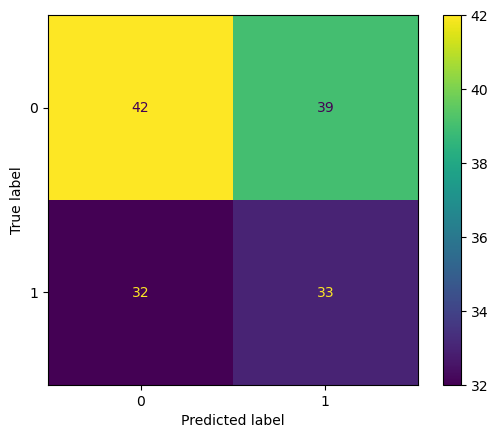

In [144]:
# source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
conf_mat = confusion_matrix(y1_test_labels, y1_pred_labels)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

Looking at the following plot, we can see that we are hitting the vanishing returns point before we reach the 15th epoch, this means increasing the epochs will not help us at this point.

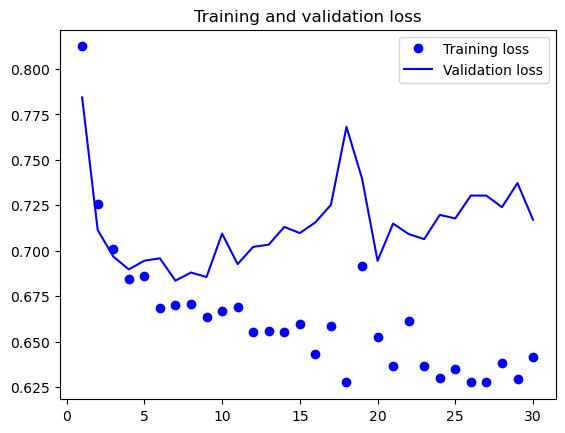

In [134]:
# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [164]:
# get the model summary
# model1.summary()

In [163]:
# get the model compile configurations
# model1.get_compile_config()

In [162]:
# get the model configurations after training
# model1.get_config()

In [160]:
# get the model weights after training
# model1.get_weights()

Get a prediction from the model given the last 6 weeks. This is to simulate how a user would get a prediction from the model. The input will be the last entry in the test set.

In [139]:
# reshape the input so it have the shape (1, 6, 12) which what the model expect as input
_input = X1_test[-1].reshape(1, X1_test.shape[1], X1_test.shape[2])
pred = model1.predict(_input)
print(f"Trend: {np.argmax(pred)}, ",f"Confidence: {np.max(pred)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Trend: 1,  Confidence: 0.7008146047592163


From here, we can start iteratively building more accurate models. The final product should look like the following snippet, where users interact with the model through a dictionary of dictionaries. Each dictionary includes the associated models and their functionalities for a given stock symbol.

In [138]:
# this is just an example for iillustrative purposes
# {
#     'PFE': 
#     {
#         'classification_model': {'model': model1, 'interval': 'week', 'predict_function':model1_predict}, 
#         'regression_model': {'model': None, 'interval': 'week', 'predict_function':None}
#     }, 
# }